In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

In [58]:
torch.manual_seed(1) # 시드 설정

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE : {DEVICE}')

DATA_FILE = '../../../Data/iris.csv'

irisDF = pd.read_csv(DATA_FILE)
irisDF.head(2)

DEVICE : cpu


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


In [59]:
# 데이터 정보 확인
irisDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [60]:
# 데이터 결측값 확인
irisDF.isna().sum()

sepal.length    0
sepal.width     0
petal.length    0
petal.width     0
variety         0
dtype: int64

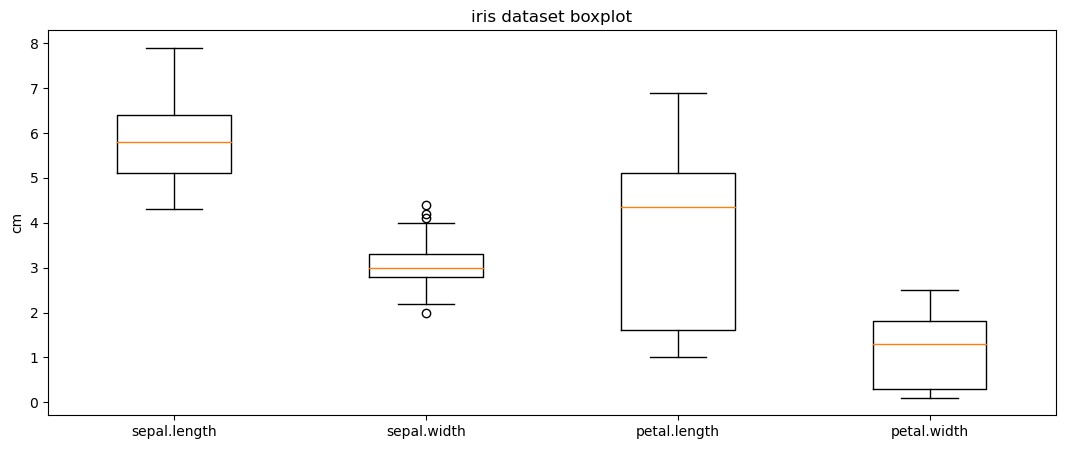

In [61]:
# 데이터 이상치 확인
plt.figure(figsize = (13, 5))
plt.boxplot(irisDF.iloc[:,:-1])
plt.title('iris dataset boxplot')
plt.ylabel('cm')
plt.xticks(range(1,5),irisDF.columns[:-1])
plt.show()

In [62]:
# 피쳐 타겟 분리
featureDF = irisDF.iloc[:,:-1]
targetDF = irisDF.iloc[:,-1]

# 타겟 라벨 인코딩
encoder = LabelEncoder()
encoder.fit(targetDF)
targetDF = pd.DataFrame(encoder.transform(targetDF), columns = ['variety'])

In [63]:
# 훈련 테스트 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, stratify=targetDF,
                                                    train_size = 0.8, random_state=42)

print(f'X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}, y_test : {y_test.shape}')

X_train : (120, 4), y_train : (120, 1)
X_test : (30, 4), y_test : (30, 1)


In [64]:
# 피쳐 정규화
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = pd.DataFrame(ss.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)
X_train_scaled.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,-1.721568,-0.332101,-1.345722,-1.323276
1,-1.124492,-1.227655,0.414505,0.651763


In [65]:
# 데이터셋 생성
from DataSet import CustomDataset

train_irisDS = CustomDataset(X_train_scaled, y_train)
test_irisDS = CustomDataset(X_test_scaled, y_test)

# 데이터셋 속성
print(f'[train] row : {train_irisDS.n_rows}, feature : {train_irisDS.n_features}')
print(f'[test] row : {test_irisDS.n_rows}, feature : {test_irisDS.n_features}')

# 데이터로더 인스턴스 생성 (지정한 배치사이즈 만큼 데이터셋에서 꺼내옴)
train_irisDL = DataLoader(train_irisDS, batch_size=10) # batch_size 기본값 : 1
test_irisDL = DataLoader(test_irisDS, batch_size=10)

[train] row : 120, feature : 4
[test] row : 30, feature : 4


In [66]:
# 모델 인스턴스 생성
from CustomModel import DeepModel

model = DeepModel(input_in=4, output_out=3, hidden_list=[30, 50, 70],
                  act_func=F.relu, is_reg=False, is_bin=False)
print(model)
summary(model)

DeepModel(
  (input_layer): Linear(in_features=4, out_features=30, bias=True)
  (hidden_layer_list): ModuleList(
    (0): Linear(in_features=30, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=70, bias=True)
  )
  (output_layer): Linear(in_features=70, out_features=3, bias=True)
)


Layer (type:depth-idx)                   Param #
DeepModel                                --
├─Linear: 1-1                            150
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       1,550
│    └─Linear: 2-2                       3,570
├─Linear: 1-3                            213
Total params: 5,483
Trainable params: 5,483
Non-trainable params: 0

In [67]:
for feature, target in train_irisDL:
    print(feature, target, sep='\n')
    break

tensor([[-1.7216, -0.3321, -1.3457, -1.3233],
        [-1.1245, -1.2277,  0.4145,  0.6518],
        [ 1.1444, -0.5560,  0.5848,  0.2568],
        [-1.1245,  0.1157, -1.2889, -1.4549],
        [-0.4080, -1.2277,  0.1306,  0.1251],
        [ 0.5473, -1.2277,  0.6984,  0.9151],
        [-0.2886, -0.7799,  0.2442,  0.1251],
        [ 0.5473, -0.5560,  0.7552,  0.3884],
        [ 2.2191, -0.1082,  1.3230,  1.4418],
        [ 2.2191,  1.6829,  1.6637,  1.3101]])
tensor([[0.],
        [2.],
        [1.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [2.],
        [2.]])


In [68]:
# 옵티마이저 (모델의 가중치와 절편 최적화)
adam_optim = optim.Adam(model.parameters(), lr=0.0001)
# 가중치, 절편을 전달하고 학습률을 설정

In [69]:
# 모델 훈련
from TorchTrainTest import training, testing
EPOCH=300
result = training(train_irisDL, test_irisDL, model, adam_optim,
                  epoch=EPOCH, is_reg=False, is_bin=False)

[Train : 10/300] Loss : 1.0014903247356415
[Test  : 10/300] Loss : 0.998203972975413
[Train : 20/300] Loss : 0.8210981537898382
[Test  : 20/300] Loss : 0.820135215918223
[Train : 30/300] Loss : 0.5988548174500465
[Test  : 30/300] Loss : 0.605815052986145
[Train : 40/300] Loss : 0.44177092363437015
[Test  : 40/300] Loss : 0.4625593026479085
[Train : 50/300] Loss : 0.344608540336291
[Test  : 50/300] Loss : 0.37626763184865314
[Train : 60/300] Loss : 0.2788636175294717
[Test  : 60/300] Loss : 0.3169928987820943
[Train : 70/300] Loss : 0.23073776563008627
[Test  : 70/300] Loss : 0.2724187175432841
[Train : 80/300] Loss : 0.19255246532460055
[Test  : 80/300] Loss : 0.23342899481455484
[Train : 90/300] Loss : 0.1601774152368307
[Test  : 90/300] Loss : 0.19799799720446268
[Train : 100/300] Loss : 0.13330339702467123
[Test  : 100/300] Loss : 0.1675696223974228
[Train : 110/300] Loss : 0.1125570268680652
[Test  : 110/300] Loss : 0.14414954433838525
[Train : 120/300] Loss : 0.09686410923798879
[

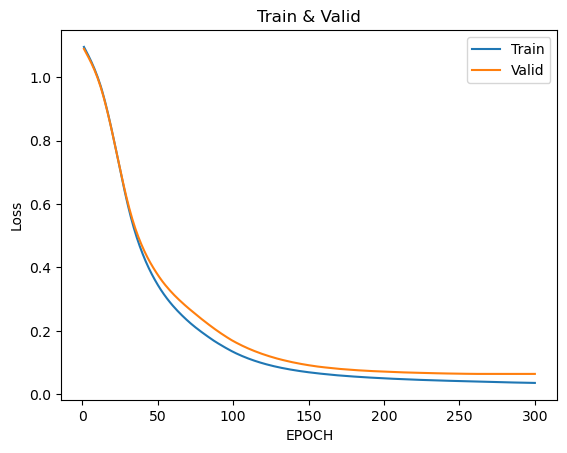

In [70]:
plt.plot(range(1, EPOCH+1), result[0], label = 'Train')
plt.plot(range(1, EPOCH+1), result[1], label = 'Valid')
plt.title('Train & Valid')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.show()

> 학습률 : 0.0001, 에포크 : 300일때 좋은 성능을 보이는 것으로 판단됨